# Vision Transformer (ViT) - Educational Tutorial

This notebook shows how a Vision Transformer processes images for classification.


In [64]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import timm
import numpy as np

torch.manual_seed(42)
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

%config InlineBackend.figure_format = 'retina'  # For high-res images in notebooks

Using device: mps


## Step 1: Load Pre-trained ViT Model

Using `timm` library (install: `pip install timm`)

In [28]:
all_vit_models = timm.list_models('vit*')
print(f"Available ViT models: {all_vit_models}")

Available ViT models: ['vit_base_mci_224', 'vit_base_patch8_224', 'vit_base_patch14_dinov2', 'vit_base_patch14_reg4_dinov2', 'vit_base_patch16_18x2_224', 'vit_base_patch16_224', 'vit_base_patch16_224_miil', 'vit_base_patch16_384', 'vit_base_patch16_clip_224', 'vit_base_patch16_clip_384', 'vit_base_patch16_clip_quickgelu_224', 'vit_base_patch16_gap_224', 'vit_base_patch16_plus_240', 'vit_base_patch16_plus_clip_240', 'vit_base_patch16_reg4_gap_256', 'vit_base_patch16_rope_reg1_gap_256', 'vit_base_patch16_rpn_224', 'vit_base_patch16_siglip_224', 'vit_base_patch16_siglip_256', 'vit_base_patch16_siglip_384', 'vit_base_patch16_siglip_512', 'vit_base_patch16_siglip_gap_224', 'vit_base_patch16_siglip_gap_256', 'vit_base_patch16_siglip_gap_384', 'vit_base_patch16_siglip_gap_512', 'vit_base_patch16_xp_224', 'vit_base_patch32_224', 'vit_base_patch32_384', 'vit_base_patch32_clip_224', 'vit_base_patch32_clip_256', 'vit_base_patch32_clip_384', 'vit_base_patch32_clip_448', 'vit_base_patch32_clip_quic

In [29]:
model_name = 'vit_tiny_patch16_224'
model = timm.create_model(model_name, pretrained=True)
model = model.to(device)
model.eval()

print(f"Model: {model.__class__.__name__}")
print(f"Patch size: 16x16")
print(f"Number of patches: {(224//16)**2} = 196")
print(f"Embedding dim: {model.embed_dim}")
print(f"Transformer layers: {len(model.blocks)}")
print(f"Attention heads: {model.blocks[0].attn.num_heads}")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Model: VisionTransformer
Patch size: 16x16
Number of patches: 196 = 196
Embedding dim: 192
Transformer layers: 12
Attention heads: 3
Number of parameters: 5717416


## Step 2: Load and Visualize CIFAR-10

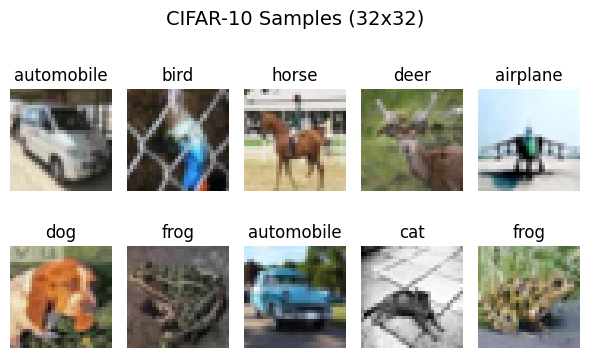

In [30]:
# CIFAR-10 classes
cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                 'dog', 'frog', 'horse', 'ship', 'truck']

# Load dataset for visualization (no normalization)
viz_dataset = datasets.CIFAR10(root='./data', train=False, download=True, 
                               transform=transforms.ToTensor())
viz_loader = DataLoader(viz_dataset, batch_size=10, shuffle=True)
viz_images, viz_labels = next(iter(viz_loader))

# Visualize
fig, axes = plt.subplots(2, 5, figsize=(6, 4))
for idx, ax in enumerate(axes.flatten()):
    img = viz_images[idx].permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.set_title(cifar_classes[viz_labels[idx]])
    ax.axis('off')
plt.suptitle('CIFAR-10 Samples (32x32)', fontsize=14)
plt.tight_layout()
plt.show()

| Step                  | What it does                                                      | Why needed                                                 |
| --------------------- | ----------------------------------------------------------------- | ---------------------------------------------------------- |
| `Resize(224,224)`     | Upscales CIFAR (32×32) → 224×224                                  | ViT trained on ImageNet expects 224×224 patches            |
| `ToTensor()`          | Converts `PIL.Image` (H×W×C, 0–255) → PyTorch tensor (C×H×W, 0–1) | PyTorch models need float tensors                          |
| `Normalize(mean,std)` | Normalizes channels with ImageNet stats                           | Makes inputs compatible with pretrained ViT’s distribution |


In [31]:
# Load raw CIFAR-10 image (no transform)
raw_dataset = datasets.CIFAR10(root='./data', train=False, download=True)
raw_image, raw_label = raw_dataset[0]

print("Before transform:")
print(f"  Type: {type(raw_image)}")
print(f"  Shape: {np.array(raw_image).shape}")  # (H, W, C)
print(f"  Value range: 0–255")

# Apply ViT transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ViT expects 224×224 input
    transforms.ToTensor(),          # Convert to tensor, scale to [0,1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

sample_image = transform(raw_image)
print("\nAfter transform:")
print(f"  Type: {type(sample_image)}")
print(f"  Shape: {sample_image.shape}")  # [C, H, W]
print(f"  Value range: [{sample_image.min():.2f}, {sample_image.max():.2f}]")

Before transform:
  Type: <class 'PIL.Image.Image'>
  Shape: (32, 32, 3)
  Value range: 0–255

After transform:
  Type: <class 'torch.Tensor'>
  Shape: torch.Size([3, 224, 224])
  Value range: [-1.90, 2.59]


In [32]:
# Load datasets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False, num_workers=2)

print(f"Train size: {len(train_dataset)} images")
print(f"Test size:  {len(test_dataset)} images")

# Check one batch
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}")  # [B, 3, 224, 224]

Train size: 50000 images
Test size:  10000 images
Batch shape: torch.Size([64, 3, 224, 224])


Let us use a smaller subset of the data

In [42]:
from torch.utils.data import Subset
import numpy as np

# pick 1/10th (≈5000 train, 1000 test)
train_subset_idx = np.random.choice(len(train_dataset), len(train_dataset)//10, replace=False)
test_subset_idx  = np.random.choice(len(test_dataset),  len(test_dataset)//10,  replace=False)

train_dataset_small = Subset(train_dataset, train_subset_idx)
test_dataset_small  = Subset(test_dataset,  test_subset_idx)

train_loader = DataLoader(train_dataset_small, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset_small,  batch_size=32, shuffle=False)

print(f"Reduced Train size: {len(train_dataset_small)}")
print(f"Reduced Test size:  {len(test_dataset_small)}")

Reduced Train size: 5000
Reduced Test size:  1000


#### Predict the class of a sample image 
If we now use a sample batch image to test the model, we get 1000 output classes since the model is pretrained on ImageNet.

In [43]:
sample_batch, label = next(iter(test_loader))
sample_batch = sample_batch.to(device)
print(f"Sample batch shape: {sample_batch.shape}")  # [B, 3, 224, 224]

with torch.no_grad():
    out = model(sample_batch)
print("Output shape:", out.shape)  # [B, num_classes]

Sample batch shape: torch.Size([32, 3, 224, 224])
Output shape: torch.Size([32, 10])


#### Inspect model


In [44]:
print("Classifier head:", model.head)

Classifier head: Linear(in_features=192, out_features=10, bias=True)


#### Replace the head for CIFAR-10

In [45]:
model.head = nn.Linear(model.embed_dim, 10)  # CIFAR-10 has 10 classes
model.head = model.head.to(device)
print("Modified classifier head:", model.head)

Modified classifier head: Linear(in_features=192, out_features=10, bias=True)


#### Predict the class of a sample image with the modified head

In [46]:
sample_image.shape

torch.Size([3, 224, 224])

In [47]:
with torch.no_grad():
    outputs = model(sample_batch)
    print(f"Output shape: {outputs.shape}  [batch, num_classes]")
    # Get predicted class
    _, predicted = torch.max(outputs, 1)
    print(f"Predicted classes: ({[cifar_classes[i] for i in predicted.tolist()]})")
# Note: The model is not trained on CIFAR-10, so predictions will be random.

Output shape: torch.Size([32, 10])  [batch, num_classes]
Predicted classes: (['bird', 'deer', 'deer', 'automobile', 'deer', 'deer', 'airplane', 'deer', 'deer', 'deer', 'deer', 'deer', 'deer', 'cat', 'deer', 'deer', 'truck', 'automobile', 'deer', 'ship', 'automobile', 'deer', 'truck', 'automobile', 'deer', 'ship', 'deer', 'ship', 'bird', 'deer', 'automobile', 'deer'])


In [48]:
# Visualise batch predictions with 

def visualize_batch(images, labels, preds=None, classes=None, n=8):
    """
    Visualize a batch of images with GT and optional predictions.
    
    Args:
        images: torch.Tensor [B, 3, H, W]
        labels: torch.Tensor [B]
        preds:  torch.Tensor [B] or None
        classes: list of class names
        n: number of images to show (default=8)
    """
    # Denormalize for visualization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    imgs = images.cpu() * std + mean
    
    # Plot
    fig, axes = plt.subplots(1, n, figsize=(3*n, 3))
    for i in range(n):
        img = imgs[i].permute(1,2,0).clamp(0,1)
        gt = classes[labels[i].item()] if classes else str(labels[i].item())
        title = f"GT: {gt}"
        if preds is not None:
            pr = classes[preds[i].item()] if classes and preds[i].item() < len(classes) else str(preds[i].item())
            title += f"\nPred: {pr}"
        axes[i].imshow(img)
        axes[i].set_title(title, fontsize=10)
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

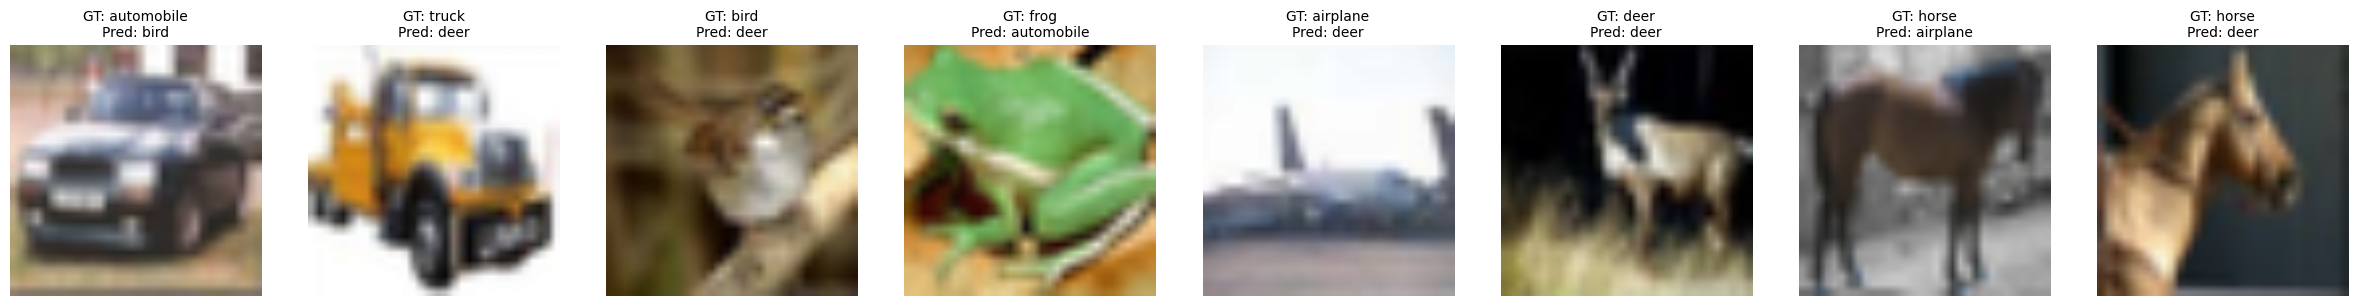

In [49]:
visualize_batch(sample_batch, label, predicted, cifar_classes, n=8)


In [50]:
def get_all_predictions(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

In [51]:
preds, labels = get_all_predictions(model, test_loader, device)


In [53]:
acc = (preds == labels).mean() * 100
print(f"Test Accuracy: {acc:.2f}%")

Test Accuracy: 8.80%


Text(0.5, 1.0, 'CIFAR-10 Confusion Matrix')

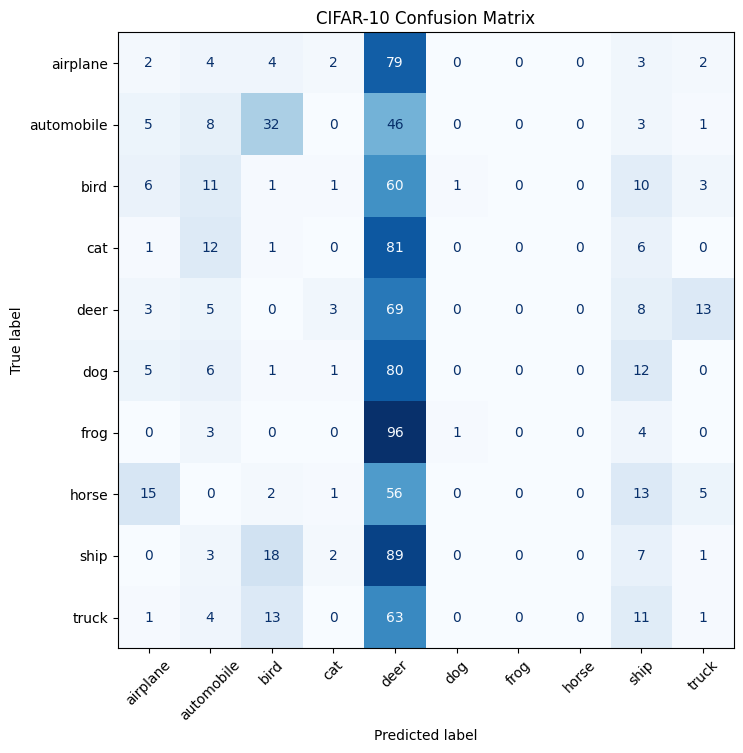

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cifar_classes)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45, colorbar=False)
plt.title("CIFAR-10 Confusion Matrix")

In [55]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [56]:
num_epochs = 5

train_losses, test_losses = [], []

for epoch in range(num_epochs):
    # ---- Train ----
    model.train()
    running_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # ---- Eval ----
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    epoch_test_loss = running_loss / len(test_loader.dataset)
    test_losses.append(epoch_test_loss)
    acc = 100 * correct / total

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {epoch_train_loss:.4f} | "
          f"Test Loss: {epoch_test_loss:.4f} | "
          f"Test Acc: {acc:.2f}%")

Epoch 1/5 | Train Loss: 0.7815 | Test Loss: 0.2773 | Test Acc: 90.80%
Epoch 2/5 | Train Loss: 0.1672 | Test Loss: 0.3274 | Test Acc: 90.30%
Epoch 3/5 | Train Loss: 0.0759 | Test Loss: 0.3071 | Test Acc: 90.90%
Epoch 4/5 | Train Loss: 0.0683 | Test Loss: 0.3336 | Test Acc: 90.40%
Epoch 5/5 | Train Loss: 0.0272 | Test Loss: 0.3881 | Test Acc: 89.90%


In [59]:
with torch.no_grad():
    outputs = model(sample_batch)
    print(f"Output shape: {outputs.shape}  [batch, num_classes]")
    # Get predicted class
    _, predicted = torch.max(outputs, 1)
    print(f"Predicted classes: ({[cifar_classes[i] for i in predicted.tolist()]})")
# Note: The model is not trained on CIFAR-10, so predictions will be random.

Output shape: torch.Size([32, 10])  [batch, num_classes]
Predicted classes: (['automobile', 'truck', 'bird', 'frog', 'airplane', 'deer', 'horse', 'deer', 'cat', 'bird', 'frog', 'airplane', 'cat', 'deer', 'automobile', 'automobile', 'deer', 'cat', 'cat', 'deer', 'frog', 'ship', 'deer', 'bird', 'automobile', 'truck', 'ship', 'automobile', 'truck', 'frog', 'ship', 'frog'])


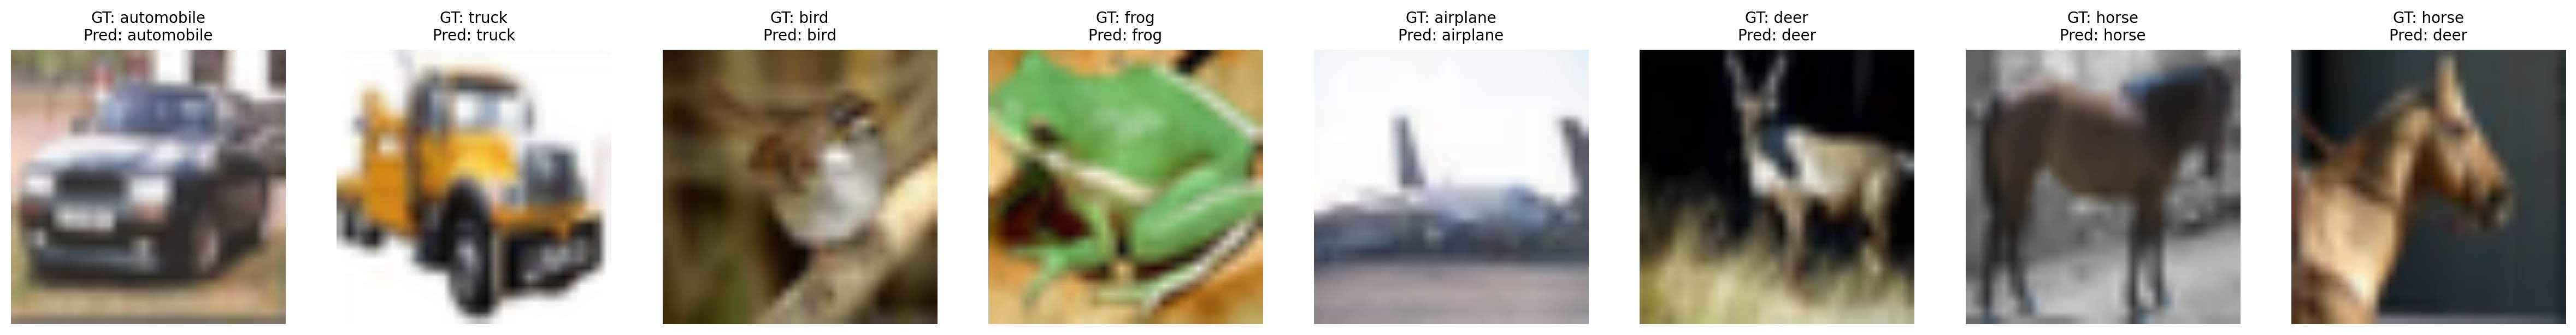

In [66]:
visualize_batch(sample_batch, label, predicted, cifar_classes, n=8)

In [61]:
preds, labels = get_all_predictions(model, test_loader, device)
acc = (preds == labels).mean() * 100
print(f"Test Accuracy: {acc:.2f}%")

Test Accuracy: 89.90%


Text(0.5, 1.0, 'CIFAR-10 Confusion Matrix')

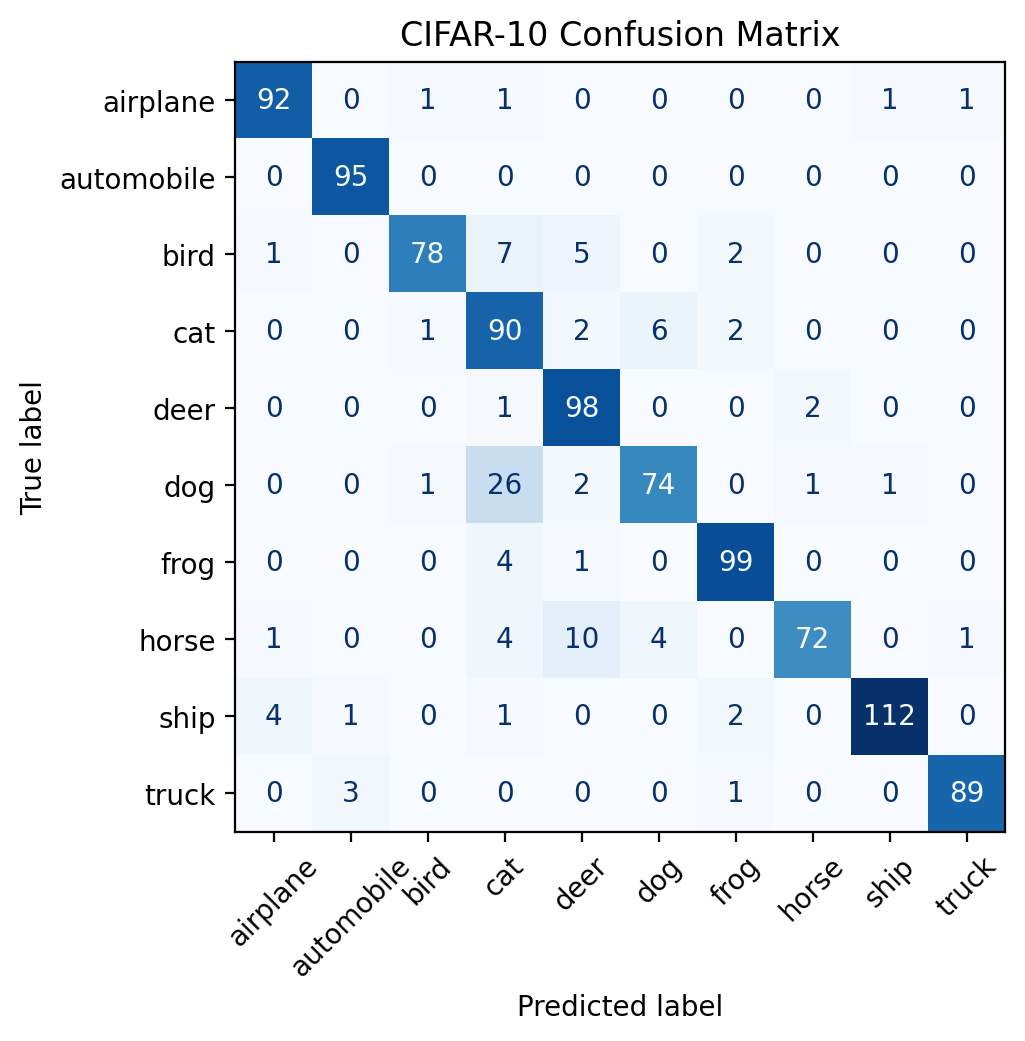

In [65]:
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cifar_classes)
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45, colorbar=False)
plt.title("CIFAR-10 Confusion Matrix")

In [68]:
model.pos_embed.shape

torch.Size([1, 197, 192])

In [70]:
model.cls_token.shape

torch.Size([1, 1, 192])

In [71]:
model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
